In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit  # Sigmoid function

def sigmoid_interpolation(start, end, steps):
    """
    Interpolates between start and end values using a sigmoid function over a specified number of steps.
    """
    x = np.linspace(-6, 6, steps)  # Range chosen to cover the significant transition of the sigmoid curve
    y = expit(x)  # Sigmoid function
    interpolated_values = start + (end - start) * y
    return interpolated_values

In [49]:
filepath = "../data/Soho Cemetery CH1.csv"
ch01 = pd.read_csv(filepath)
ch01 = ch01.ffill()
ch01["timestamp"] = pd.to_datetime(ch01.Epoch)
ch01 = ch01[["CH1", "timestamp"]]
ch01.head()

,CH1,timestamp
0,159.81427,2023-06-21 00:00:00
1,160.19821,2023-06-21 01:00:00
2,160.19821,2023-06-21 02:00:00
3,160.19821,2023-06-21 03:00:00
4,160.19821,2023-06-21 04:00:00


In [50]:
# Normalize each column to the range [0, 1]
ch01["CH1_normalized"] = (ch01["CH1"] - ch01["CH1"].min()) / (ch01["CH1"].max() - ch01["CH1"].min())
ch01.set_index("timestamp", inplace=True)
ch01 = ch01[["CH1_normalized"]]
ch01.head()

,CH1_normalized
timestamp,
2023-06-21 00:00:00,0.085175
2023-06-21 01:00:00,0.087315
2023-06-21 02:00:00,0.087315
2023-06-21 03:00:00,0.087315
2023-06-21 04:00:00,0.087315


In [51]:
ch01.shape

(8760, 1)

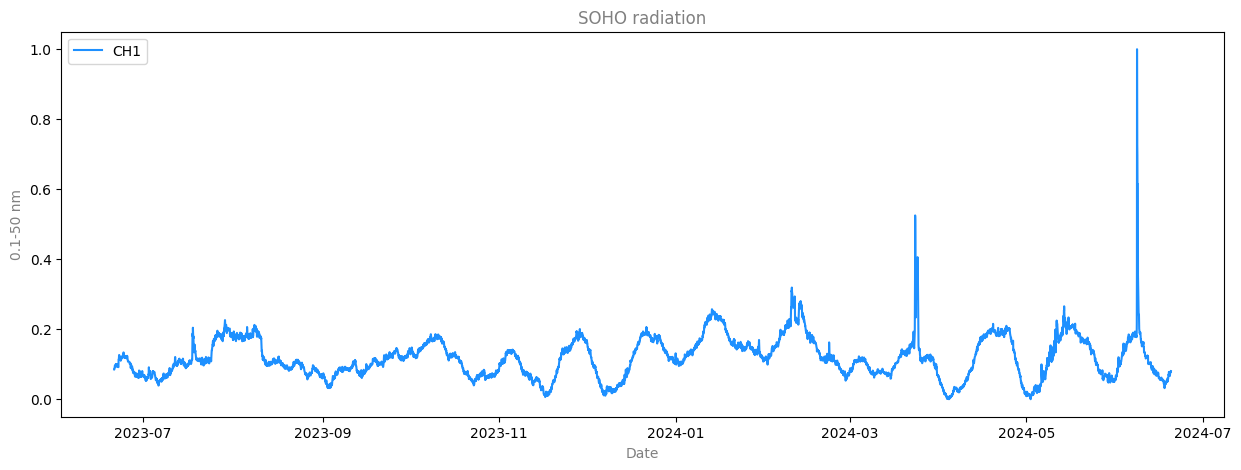

In [52]:
# Plotting
plt.figure(figsize=(15, 5))
plt.plot(ch01.index, ch01["CH1_normalized"], color="dodgerblue", label="CH1")
plt.legend(loc='upper left')
plt.xlabel('Date', color='grey')
plt.ylabel('0.1-50 nm', color='grey')
plt.title('SOHO radiation', color='grey')
plt.legend(loc='upper left')
plt.savefig("../img/soho.png")
plt.show()

In [53]:
# Define the desired frequency for resampling
desired_freq = '30min'  # 30-minute intervals

# Initialize an empty DataFrame to hold interpolated data
interpolated_data = pd.DataFrame()


In [54]:
# Process each column separately
for column in ch01.columns:
    # Drop NaN values to work with actual data points
    data = ch01[column].dropna()

    # Create a new Series to hold the interpolated series
    interpolated_series = pd.Series(dtype=float)

    # Iterate over each pair of consecutive data points
    for i in range(len(data) - 1):
        start_time = data.index[i]
        end_time = data.index[i + 1]
        start_value = data.iloc[i]
        end_value = data.iloc[i + 1]

        # Generate timestamps between start and end at the desired frequency
        timestamps = pd.date_range(start=start_time, end=end_time, freq=desired_freq)[1:-1]

        # Perform sigmoid interpolation
        interpolated_values = sigmoid_interpolation(start_value, end_value, len(timestamps))

        # Create a temporary series with interpolated values
        temp_series = pd.Series(interpolated_values, index=timestamps)

        # Concatenate the temporary series to the interpolated series
        interpolated_series = pd.concat([interpolated_series, temp_series])

    # Combine with original data
    interpolated_series = pd.concat([interpolated_series, data])

    # Sort the index to maintain chronological order
    interpolated_series = interpolated_series.sort_index()

    # Add the interpolated series to the DataFrame
    interpolated_data[column] = interpolated_series

# Resample the interpolated data to ensure consistent 30-minute intervals
interpolated_data = interpolated_data.resample(desired_freq).mean()

# Forward-fill any remaining NaN values
interpolated_data = interpolated_data.ffill()


# Define the start and end dates for trimming
start_date = pd.Timestamp("2023-06-21 15:00:00")
end_date = pd.Timestamp("2024-06-20 20:30:00")

# Ensure the end_date is included in the index
if end_date not in interpolated_data.index:
    # Add the end_date to the index with NaN values
    interpolated_data.loc[end_date] = np.nan
    # Sort the index to maintain chronological order
    interpolated_data = interpolated_data.sort_index()
    # Forward-fill the NaN value at end_date
    interpolated_data = interpolated_data.ffill()

# Trim the data to the specified date range
trimmed_data = interpolated_data.loc[start_date:end_date]

# Define the start and end dates for trimming
start_date = pd.Timestamp("2023-06-21 15:00:00")
end_date = pd.Timestamp("2024-06-20 20:30:00")

# Ensure the end_date is included in the index
if end_date not in interpolated_data.index:
    # Add the end_date to the index with NaN values
    interpolated_data.loc[end_date] = np.nan
    # Sort the index to maintain chronological order
    interpolated_data = interpolated_data.sort_index()
    # Forward-fill the NaN value at end_date
    interpolated_data = interpolated_data.ffill()

# Trim the data to the specified date range
trimmed_data = interpolated_data.loc[start_date:end_date]

trimmed_data.tail()

/var/folders/ww/rg8zlhq16mqg0kz1wk66r9b00000gn/T/ipykernel_13756/3679830836.py:26: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  interpolated_series = pd.concat([interpolated_series, temp_series])


,CH1_normalized
2024-06-19 21:30:00,0.077617
2024-06-19 22:00:00,0.078398
2024-06-19 22:30:00,0.078403
2024-06-19 23:00:00,0.080405
2024-06-20 20:30:00,0.080405


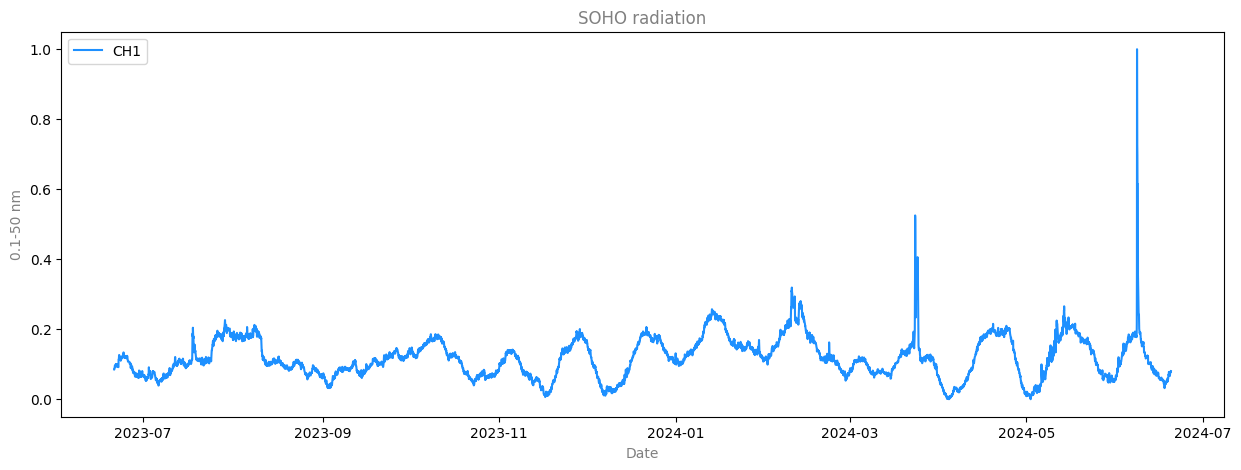

In [55]:
# Plotting
plt.figure(figsize=(15, 5))
plt.plot(ch01.index, ch01["CH1_normalized"], color="dodgerblue", label="CH1")
plt.legend(loc='upper left')
plt.xlabel('Date', color='grey')
plt.ylabel('0.1-50 nm', color='grey')
plt.title('SOHO radiation', color='grey')
plt.legend(loc='upper left')
plt.savefig("../img/soho.png")
plt.show()

In [56]:
ch01.to_csv("../data/soho_01-50nm.csv")